# Квадраты со всеми вершинами

[смысл алгоритма понятно описан тут](http://www.cat-in-web.ru/notebook/opredelenie-peresecheniya-pryamougolnikov/)

К этому нужно добавить то, что в нашем случае прямоугольники могут располагаться под углом. ПОэтому когда угол прямоугольника НЕ будет кратным 90 градусам (не параллелен осям), будем "строить" уравнения прямых, образующих стороны прямоугольника и использовать то же неравенство, что в простом случае.

Также учтем что нужно следить за тем что такое "выше", "ниже" и тд, тк при повороте, например, на 180 верх и низ меняются местами.

nupmy это модуль для удобной работы с массивами

matplotlib для графиков

In [1]:
import numpy as np
import pylab
import matplotlib.path
import matplotlib.pyplot as plt

## Две функции ниже нужны если решать задачу с помощью переноса системы координат в прямоугольник, сейчас не используются

In [2]:
# function to rotate a vector by a certain angle
def rotate_vector(vec, angle, deg=False):
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    rotated_vector = Vector(vec.x*cos_angle - vec.y*sin_angle, vec.x*sin_angle + vec.y*cos_angle)
    return rotated_vector

In [3]:
# function to rotate a vector by a certain angle back
def rotate_vector_back(vec, angle, deg=False):
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    rotated_vector = Vector(vec.x*cos_angle + vec.y*sin_angle, vec.x*sin_angle - vec.y*cos_angle)
    return rotated_vector

In [4]:
def change_coord(vertex, angle, center):
    rot_angle = -angle#angle%(2*np.pi)
    return rotate_vector(vertex, angle) - center

## Это класс точки, я его добавила для удобства.

Принимает координату х,у

Доопределено сложение и вычитание

__repr__ просто вывод

In [5]:
class Vector:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    # function to add two vectors
    def __add__(self, other):
        return Vector(self.x+other.x, self.y+other.y)

    # function to subtract vectors
    def __sub__(self, other):
        return Vector(self.x-other.x, self.y-other.y)

    # make the vector printable
    def __repr__(self):
        return "(%s, %s)" % (self.x, self.y)   

## Класс прямоугольника (слоя) как вы его описали

Ниже все будет нарисовано в привычной отраженной системе координат, на решение это не влияет.

Точки B, C, D доопределяются так:

Мы крутим прямоугольники вокруг фиксированной точки А(х,у), для этого надо перенести ноль в точку А, покрутить вектор, и вернуть все на место. Таким образом нам известны координаты всех 4 точек независимо от угла.

In [6]:
class Layer:
    def __init__(self, x, y, width, height, angle):
        self.A = Vector(x, y)
        self.angle = angle
        self.width = width
        self.height = height
        
        # координаты в исходной системе координат
        
        self.B = self.A + rotate_vector(Vector(width, 0), self.angle) # Vector(self.A.x + self.width*cos, self.A.y - self.width*sin) 
        self.C = self.A + rotate_vector(Vector(width, height), self.angle) # Vector(self.A.x + self.height*cos, self.A.y - self.height*sin)
        self.D = self.A + rotate_vector(Vector(0, height), self.angle) # Vector(self.A.x + d*cos, self.A.y - d*sin) 
         
    def get_vertex(self):
        return [self.A, self.B, self.C, self.D]
            
    def __repr__(self):
        return "\nA%s\nB%s\nC%s\nD%s" % (self.A, self.B, self.C, self.D)

## Функция чтобы все рисовать

In [7]:
def draw_rects(rect1, rect2):
    def set_xy(rect):
        xy = np.array([[rect.A.x, rect.A.y], [rect.B.x, rect.B.y], [rect.C.x, rect.C.y], [rect.D.x, rect.D.y]])
        xs = xy[:, 0]
        ys = xy[:, 1]
        return xy, xs, ys
    
    #print(rect1)
    #print(rect2)
    xy1, xs1, ys1 = set_xy(rect1)
    xy2, xs2, ys2 = set_xy(rect2)
    
    plt.figure(figsize=(6, 6))
    plt.scatter(xs1, ys1, s=70, color='red')
    plt.scatter(xs2, ys2, s=70, color='blue')

    r1 = plt.Polygon(xy1, color='red', fill=0)
    r2 = plt.Polygon(xy2, color='blue', fill=0)
    plt.gca().add_patch(r1)
    plt.gca().add_patch(r2)
    plt.xlim(-5, 10)
    plt.ylim(-5, 10)
    plt.show()        

## Проверка

Функция для определения какая вершина самая нижняя, самая верхняя, самая левая и самая праваяя (в обычном смысле). 

Зачем именно так, нарисую табличку на бумажке.
Для циклической перестановки вершин в зависимости от угла.

In [8]:
def rotate_left(seq, n):
    #return (seq[n-1::-1] + seq[:n-1:-1])[::-1]
    return seq[4-n:] + seq[:4-n]

уравнение прямой y = kx + b, можем найти k, b для каждой из сторон.

In [9]:
def make_line_by_2_points(p1, p2):
    k = (p1.y - p2.y) / (p1.x - p2.x)
    b = p2.y - k*p2.x
    return k, b

так как мы можем расположить вершины в нужном нам порядке осталось проверить условие по неравенству

- rec_vertex[0] самая нижняя

- rec_vertex[1] самая правая

- rec_vertex[2] самая верхняя

- rec_vertex[3] самая левая

In [61]:
def check_intersection(rec1, rec2):
  
    rec1_vertex = rotate_left(rec1.get_vertex(), int(rec1.angle//(np.pi/2)))
    rec2_vertex = rotate_left(rec2.get_vertex(), int(rec2.angle//(np.pi/2)))
    
    # rec1 который кривой
    # rec2 который ровный
    def compare_line_and_vertex(rec1_vertex, rec2_vertex):
        top = make_line_by_2_points(rec1_vertex[2], rec1_vertex[3])
        bottom = make_line_by_2_points(rec1_vertex[0], rec1_vertex[1])
        left = make_line_by_2_points(rec1_vertex[3], rec1_vertex[0])
        right = make_line_by_2_points(rec1_vertex[1], rec1_vertex[2])

        return not (rec2_vertex[0].y > top[0]*rec2_vertex[0].x + top[1] or 
                    rec2_vertex[2].y < bottom[0]*rec2_vertex[2].x + bottom[1] or
                    rec2_vertex[3].y > right[0]*rec2_vertex[3].x + right[1] or
                    rec2_vertex[1].y < left[0]*rec2_vertex[1].x + left[1])
    
    def compare_vertex(rec1_vertex, rec2_vertex):
        
        return not (rec1_vertex[3].y < rec2_vertex[1].y or 
                    rec1_vertex[1].y > rec2_vertex[3].y or 
                    rec1_vertex[1].x < rec2_vertex[3].x or 
                    rec1_vertex[3].x > rec2_vertex[1].x)
    

    # сюда входят случаи нулевой разницы поэтому доп проверка ниже не нужна
    if rec1.angle%(np.pi/2) == 0: 
        if rec2.angle%(np.pi/2) == 0:
            print("\ncase 1: both parallel")
            return compare_vertex(rec1_vertex, rec2_vertex)                 
        # rec1|| rec2 no
        print("\ncase 2: first parallel, second no")
        return compare_line_and_vertex(rec2_vertex, rec1_vertex) #or compare_vertex(rec2_vertex, rec1_vertex))
        
    if rec2.angle%(np.pi/2) == 0:
    # rec2|| rec1 no  or rec1 no rec2 no
        print("\ncase 3: second parallel, first no")
        return compare_line_and_vertex(rec1_vertex, rec2_vertex) #or compare_vertex(rec1_vertex, rec2_vertex))
        
    print("\ncase 4: both not parallel")
    return compare_line_and_vertex(rec1_vertex, rec2_vertex)

Проверить выход за границы очень просто.

Снова располагаем вершины в нужном порядке. Проверяем что самая верхняя ниже y_max самая нижняя выше 0, самая левая больше 0.

In [11]:
def check_limit(rec, y_max):
    rec_vertex = rotate_left(rec.get_vertex(), int(rec.angle//(np.pi/2)))
    return (rec_vertex[3].x >= 0 and 
            rec_vertex[0].y >= 0 and
            rec_vertex[2].y < y_max)

## Примеры

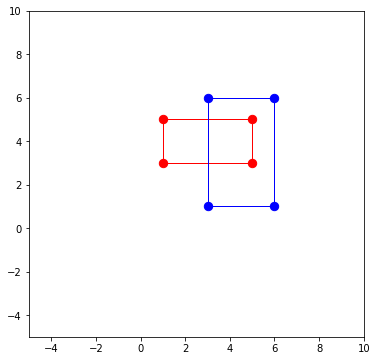


case 1: both parallel


True

In [64]:
l1 = Layer(1, 3, 4, 2, 0)
l2 = Layer(3, 1, 3, 5, 0)
draw_rects(l1, l2)
check_intersection(l1, l2)
#пересекаются

In [65]:
check_limit(l6, 6)

False

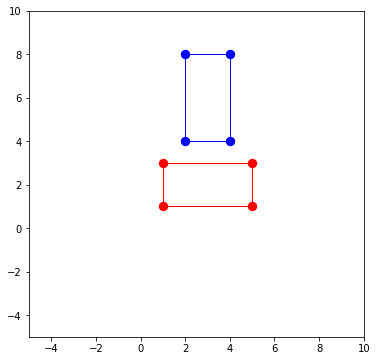


case 1: both parallel


False

In [66]:
l3 = Layer(1,1,4,2,0) #np.pi/2
l4 = Layer(2,4,2,4,0)
draw_rects(l3, l4)
check_intersection(l3, l4)
# не пересекаются

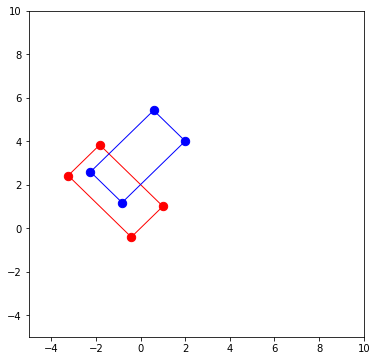


case 4: both not parallel


True

In [67]:
l5 = Layer(1,1,4,2, 3*np.pi/4) #np.pi/2
l6 = Layer(2,4,2,4, 3*np.pi/4)
draw_rects(l5, l6)
check_intersection(l5, l6)
#пересекаются

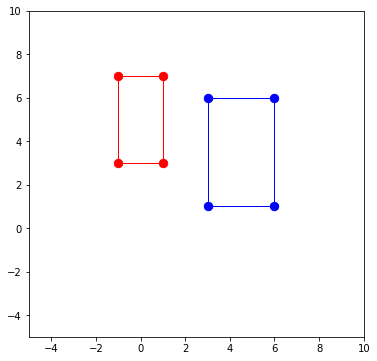


case 1: both parallel


False

In [68]:
l7 = Layer(1, 3, 4, 2, np.pi/2)
l8 = Layer(3, 1, 3, 5, 0)
draw_rects(l7, l8)
check_intersection(l7, l8)
# не пересекаются

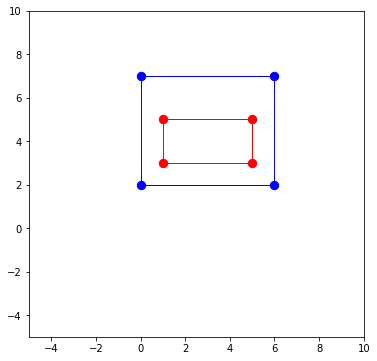


case 1: both parallel


True

In [69]:
l9 = Layer(0, 2, 6, 5, 0)
draw_rects(l1, l9)
check_intersection(l1, l9)
# пересекаются

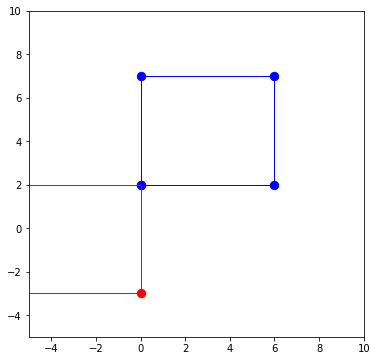


case 1: both parallel


False

In [70]:
l10 = Layer(0, 2, 6, 5, np.pi)
draw_rects(l10, l9)
check_intersection(l10, l9)
# не пересекаются???

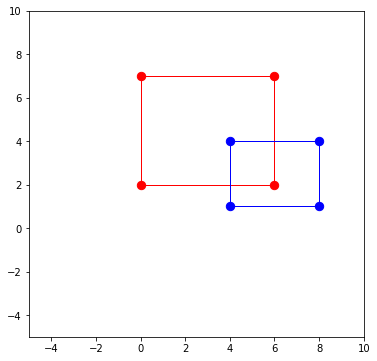


case 1: both parallel


True

In [71]:
l11 = Layer(4, 1, 4, 3, 0)
draw_rects(l9, l11)
check_intersection(l9, l11)
# пересекаются

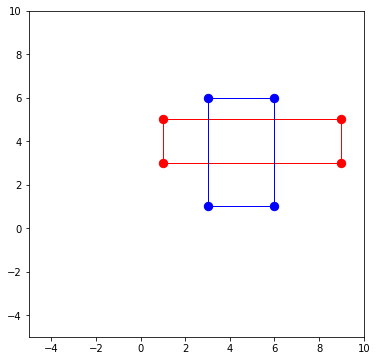


case 1: both parallel


True

In [72]:
l12 = Layer(1, 3, 8, 2, 0)
draw_rects(l12, l2)
check_intersection(l12, l2)
#пересекаются

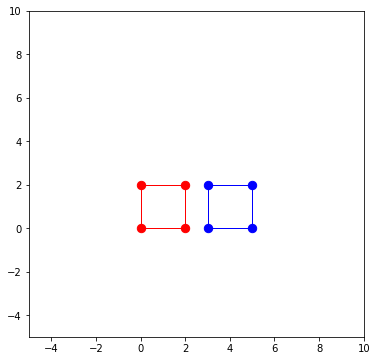


case 1: both parallel


False

In [73]:
l13 = Layer(0, 0, 2, 2, 0)
l14 = Layer(3, 0, 2, 2, 0)
draw_rects(l13, l14)
check_intersection(l13, l14)
# не пересекаются

In [74]:
def check(x1, y1, w1, h1, a1, x2, y2, w2, h2, a2):
    l1 = Layer(x1, y1, w1, h1, a1)
    l2 = Layer(x2, y2, w2, h2, a2)
    draw_rects(l1, l2)
    print(check_intersection(l1, l2))

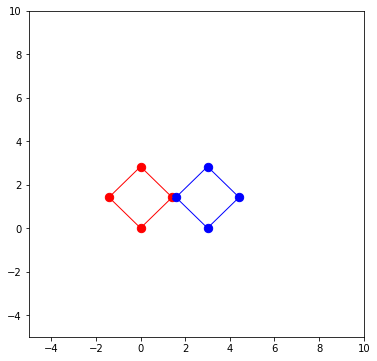


case 4: both not parallel
False


In [75]:
check(0, 0, 2, 2, np.pi/4, 3, 0, 2, 2, np.pi/4)

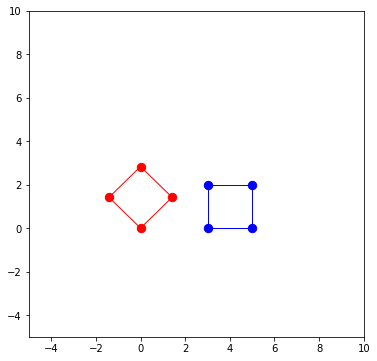


case 3: second parallel, first no
False


In [76]:
check(0, 0, 2, 2, np.pi/4, 3, 0, 2, 2, 0)

## ЕТО РАБОТАЕТ НЕПРАВИЛЬНО

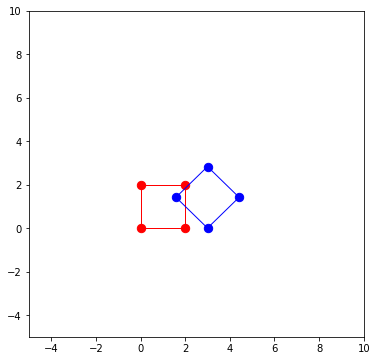


case 2: first parallel, second no
False


In [77]:
check(0, 0, 2, 2, 0, 3, 0, 2, 2, np.pi/4)

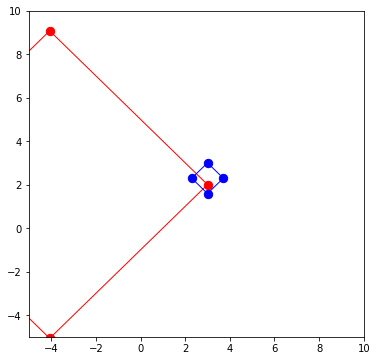


case 4: both not parallel
True


In [78]:
check(3, 2, 10,10, 3*np.pi/4, 3, 3, 1, 1, 5*np.pi/4)

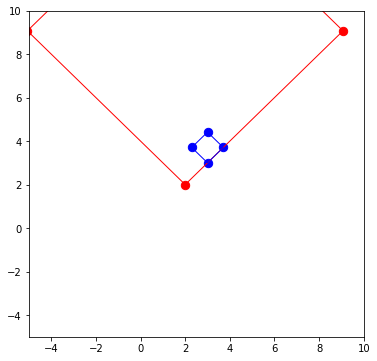


case 4: both not parallel
True


In [79]:
check(2, 2, 10,10, np.pi/4, 3, 3, 1, 1, np.pi/4)

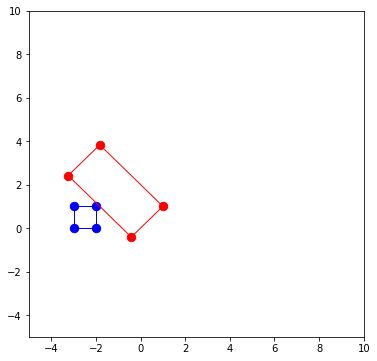


case 3: second parallel, first no


False

In [80]:
l16 = Layer(-3, 0, 1, 1, 0)
draw_rects(l5, l16)
check_intersection(l5, l16)
#не пересекаются

## Черновик

def check_intersection(rec1, rec2):
  
    rec1_vertex = rotate_left(rec1.get_vertex(), int(rec1.angle//(np.pi/2)))
    rec2_vertex = rotate_left(rec2.get_vertex(), int(rec2.angle//(np.pi/2)))
    
    #print(rec1_vertex)
    #print(rec2_vertex)
    def compare_vertex(rec1_vertex, rec2_vertex):
        return not (rec1_vertex[3].y < rec2_vertex[1].y or 
                    rec1_vertex[1].y > rec2_vertex[3].y or 
                    rec1_vertex[1].x < rec2_vertex[3].x or 
                    rec1_vertex[3].x > rec2_vertex[1].x)
    
    # сюда входят случаи нулевой разницы поэтому доп проверка ниже не нужна
    if rec1.angle%(np.pi/2) == 0 or rec2.angle%(np.pi/2) == 0:
        return not (rec1_vertex[3].y < rec2_vertex[1].y or 
                    rec1_vertex[1].y > rec2_vertex[3].y or 
                    rec1_vertex[1].x < rec2_vertex[3].x or 
                    rec1_vertex[3].x > rec2_vertex[1].x)
     
    else:
        top = make_line_by_2_points(rec1_vertex[2], rec1_vertex[3])
        bottom = make_line_by_2_points(rec1_vertex[0], rec1_vertex[1])
        left = make_line_by_2_points(rec1_vertex[3], rec1_vertex[0])
        right = make_line_by_2_points(rec1_vertex[1], rec1_vertex[2])
        
        # проверка по условию
        
        return not (rec2_vertex[0].y > top[0]*rec2_vertex[0].x + top[1] or 
                    rec2_vertex[2].y < bottom[0]*rec2_vertex[2].x + bottom[1] or
                    rec2_vertex[3].y > right[0]*rec2_vertex[3].x + right[1] or
                    rec2_vertex[1].y < left[0]*rec2_vertex[1].x + left[1])

In [20]:
import itertools
import pylab
import matplotlib.path
import matplotlib.pyplot as plt
import numpy as np
import math
from pprint import pprint
from itertools import permutations

class Layer:
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        
        self.diagonal_x = x + width
        self.diagonal_y = y + height
        
    def __repr__(self):
        return "(x, y): (%s, %s);\n(x1, y1): (%s, %s)" % (self.x, self.y, self.diagonal_x, self.diagonal_y)
    
    #work for stright 

def check_intersection(rec1, rec2):
    return not (rec1.y < rec2.diagonal_y or rec1.diagonal_y > rec2.y or rec1.diagonal_x < rec2.x or rec1.x > rec2.diagonal_x)

l1 = Layer(1, 5, 4, -2)
l2 = Layer(3, 6, 3, -5)

l3 = Layer(1,3,4,-2)
l4 = Layer(2,8,2,-4)


class Layer:
    def __init__(self, x, y, width, height, angle):
        self.Ax = x
        self.Ay = y
        self.angle = angle
        self.width = width
        self.height = height
        
        #diagonal_x = x + width
        #diagonal_y = y + height
        
        
        cos = np.cos(angle)
        
        self.Bx = self.Ax + width*np.cos(angle)
        self.By = self.Ay - width*np.sin(angle)
        self.Dx = 
        self.Dy = 
        
    def __repr__(self):
        return "(x, y): (%s, %s);\n(x1, y1): (%s, %s)" % (self.x, self.y, self.diagonal_x, self.diagonal_y)
    
    
  #A1 = Vector(0,0)
        #B1 = Vector(rec1.width, 0)
        #C1 = Vector(rec1.width, rec1.height)
        #D1 = Vector(0, rec1.height)
        
        #A2 = change_coord(rec2.A, rec1.angle, rec1.A)
        #B2 = change_coord(rec2.B, rec1.angle, rec1.A)
        #C2 = change_coord(rec2.C, rec1.angle, rec1.A)
        #D2 = change_coord(rec2.D, rec1.angle, rec1.A)
        
        
         #plt.scatter([A1.x, B1.x, C1.x, D1.x], [A1.y, B1.y, C1.y, D1.y], s=70, color='red')
        #plt.scatter([A2.x, B2.x, C2.x, D2.x], [A2.y, B2.y, C2.y, D2.y], s=70, color='blue')
        
        #return not (A1.y < C2.y or C1.y > A2.y or C1.x < A2.x or A1.x > C2.x)
        
        
 if rec1.angle%(np.pi/2) == 0 and rec2.angle%(np.pi/2) == 0:
        return not (rec1.A.y < rec2.C.y or rec1.C.y > rec2.A.y or rec1.C.x < rec2.A.x or rec1.A.x > rec2.C.x)

In [ ]:
 print("LALALALAL")
        # проверка по условию
        print(rec2_vertex[0].y > top[0]*rec2_vertex[0].x + top[1])
        print(rec2_vertex[2].y < bottom[0]*rec2_vertex[2].x + bottom[1])
        print(rec2_vertex[3].y > right[0]*rec2_vertex[3].x + right[1])
        print(rec2_vertex[1].y < left[0]*rec2_vertex[1].x + left[1])
        
        print("\n\nvertex y", rec2_vertex[1].y)
        print("left", left)
        print("rec2_vertex[1].x", rec2_vertex[1].x)
        print("left[0]*rec2_vertex[1].x + left[1]", left[0]*rec2_vertex[1].x + left[1], "\n\n")

In [ ]:
print(rec1_vertex[3].y < rec2_vertex[1].y)
        print(rec1_vertex[1].y > rec2_vertex[3].y)
        print(rec1_vertex[1].x < rec2_vertex[3].x)
        print(rec1_vertex[3].x > rec2_vertex[1].x)

In [ ]:
print("\ncase 3: second parallel, first no")
        print("rec1 not", rec1)
        
        print("line cond", compare_line_and_vertex(rec1_vertex, rec2_vertex))
        print("vert cond", compare_vertex(rec1_vertex, rec2_vertex))

In [ ]:
#print("rec2 not", rec2)
        
        print("line cond", compare_line_and_vertex(rec2_vertex, rec1_vertex))
        print("vert cond", compare_vertex(rec2_vertex, rec1_vertex))

In [ ]:
 #return not (rec1_vertex[3].y < rec2_vertex[1].y or 
                        #rec1_vertex[1].y > rec2_vertex[3].y or 
                        #rec1_vertex[1].x < rec2_vertex[3].x or 
                        #rec1_vertex[3].x > rec2_vertex[1].x)